In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from cgmsquared import clustering as cgm2_cluster
from cgmsquared import clustering2 as c2
import haloclustering.evalulate_model as evaluate
import emcee
import corner
import pandas as pd
import scipy.special as sc
from astropy.cosmology import Planck15 as cosmo
import haloclustering.plot as hplt
import haloclustering.data as datamodule

from multiprocessing import Pool
from multiprocessing import cpu_count
import seaborn as sns

from scipy.stats import binned_statistic

plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16
from haloclustering import models
from astropy.stats import binned_binom_proportion

In [2]:
# get data
df = pd.read_csv('../data/cgm2_casbah_velo_split_table_with_comoving_rho_and_mass.csv')
df['log_rho'] = np.log10(df.rho)
df.sort_values('rho', inplace=True)
# df.rho = df.rho / 1000 # convert to Mpc
df = df.query("(HM_0_500 != 'indeterminate') & (7 < mstars < 12)")
df['Hz'] = cosmo.H(df.z).value
vmax = 500.0 # km/s

df.dropna(subset=['mstars'], inplace=True)
massmask = df.eval("8 < mstars < 10.5").values
df['logm'] = df.mstars
df.mstars = 10**df.mstars


outcomes = df.HM_0_500.values
hits = (outcomes == "hit") & massmask
misses = (outcomes == "miss") & massmask


In [3]:
df['survey'] = np.where(df.user == 'mwilde', r"CGM$^2$", r"CASBaH")

In [4]:
dfnew = df.copy()

# plot the summary of the data sets

<ipython-input-28-d1d423957a77>:23: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "png" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../figures/combined_data_mass_z.png', png=300);


<Figure size 720x504 with 0 Axes>

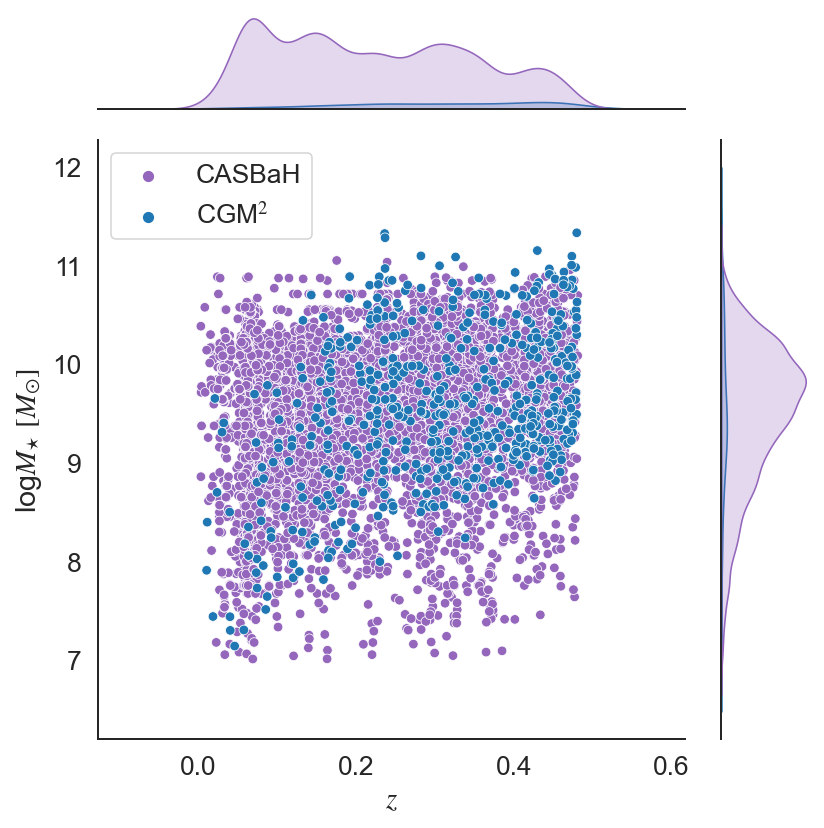

In [28]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)

dfnew.sort_values('survey', inplace=True)
sns.set_theme(style="ticks")
s = [r'$z$', r'log$M_{\star}$ $[M_{\odot}]$']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=dfnew, x="z", y="logm", hue='survey',
                    palette=["tab:purple", "tab:blue"],
                    legend=True)

    g.set_axis_labels(s[0], s[1])
    # g.fig.get_axes()[0].legend([r'CGM$^2$', r'CASBaH'], loc='upper left')
    ax = g.fig.get_axes()[0]
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    plt.tight_layout()
    plt.savefig('../figures/combined_data_mass_z.png', png=300);

In [26]:
dfnew['rho_mpc'] = dfnew.rho / 1000

<Figure size 720x504 with 0 Axes>

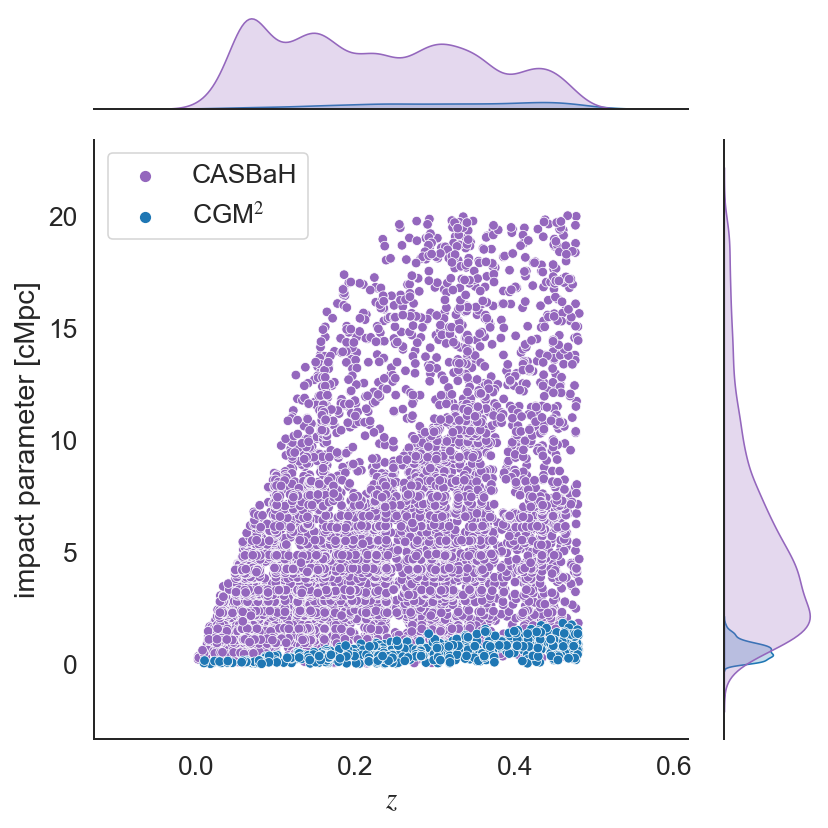

In [51]:
joint_kws=dict(gridsize=30)
plt.figure(figsize=(10,7))


# df.sort_values("survey", inplace=True)

dfnew.sort_values('survey', inplace=True)
sns.set_theme(style="ticks")
s = [r'$z$', r'impact parameter [cMpc]']
with sns.axes_style('white'):
    sns.set_context("paper", font_scale=1.5)

    g = sns.jointplot(data=dfnew, x="z", y="rho_mpc", hue='survey',
                    palette=["tab:purple", "tab:blue"],
                    legend=True)

    g.set_axis_labels(s[0], s[1])
    # g.fig.get_axes()[0].legend([r'CGM$^2$', r'CASBaH'], loc='upper left')
    ax = g.fig.get_axes()[0]
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=labels)
    plt.tight_layout()
    plt.savefig('../figures/combined_data_mass_rho.pdf', dpi=300);

# read in the covering fractions from the emcee samplers

In [6]:
def log_probability(params, rho_gal_com, z_gal, Hz, vmax, hits, misses, mass):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params
    lp = log_prior(params)

    if not np.isfinite(lp):
        return -np.inf, np.full(mass.shape, np.nan)
    logl, prob_hit = log_likelihood(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass, hits, misses)
    logprob = lp + logl
    return logprob, prob_hit

In [7]:
import pickle
pkl_file = '../exclusion-model/exclusion_model_gauss_1h_sampler.pkl'
infile = open(pkl_file, "rb")
sampler = pickle.load(infile)
infile.close()

pkl_file = '../exclusion-model/model_2h_w_beta_sampler.pkl'
infile = open(pkl_file, "rb")
sampler_2h = pickle.load(infile)
infile.close()

In [33]:
df.shape

(7244, 26)

In [8]:
df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))

1368
3816
1790


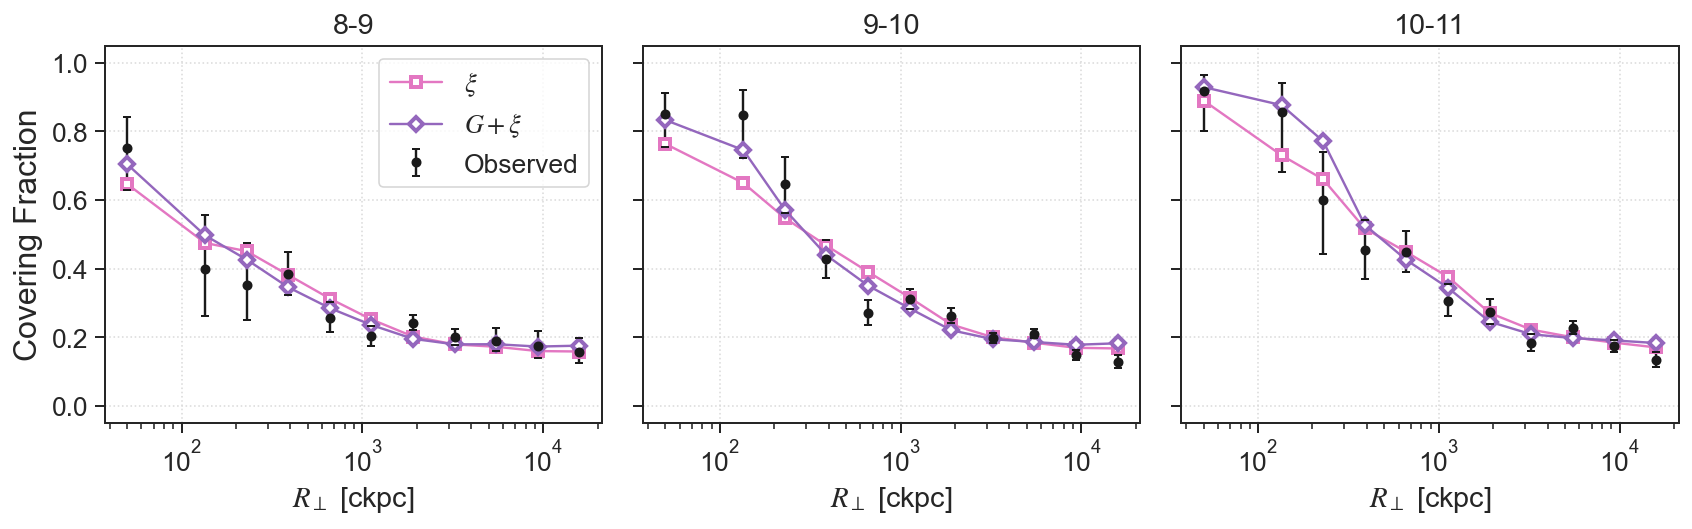

In [34]:
#rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

rho_bins = np.concatenate([[0, 200], np.geomspace(400, 20e3, 6)])
rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])

bin_ctr = 0.5*(rho_bins[1:] + rho_bins[:-1])
#rho_bins = np.geomspace(20, 20e3, 15)
#np.concatenate([[0, 100, 200], np.geomspace(300, 20e3, 7)])
# plt.close("all")

fig, axes = plt.subplots(1, 3, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

if False:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 11]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    print(ssdf.__len__())
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
                                                 interval='jeffreys')

    # models
    model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    
    ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label=r'$\xi$')
    ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label=r'$G + \xi$')

    # data
    ax.errorbar(bin_ctr_p, p, yerr=perr, ls='none', marker='o', label='Observed'.format(*rng), capsize=2,
        color='k', markersize=4)
        
    ax.set_title('{}-{}'.format(*rng))
    ax.set_xlabel(r"$R_{\perp}$ [ckpc]")
    ax.grid(ls=':', color='gainsboro')
axes[0].legend()
plt.xscale('log');

if False:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    plt.ylim(-0.05, 1.05)
# axes[1].set_xlabel('IP (ckpc)', fontsize=16)
axes[0].set_ylabel('Covering Fraction', fontsize=16);

plt.tight_layout();
plt.savefig('../figures/cf_plots_comparison.pdf', dpi=300)

In [10]:
ssdf.cf_model.values, model[0], ssdf.rho.values

(array([0.95033706, 0.90956724, 0.9506636 , ..., 0.20382108, 0.2050756 ,
        0.18106789]),
 array([0.92879349, 0.87614935, 0.77117645, 0.5272927 , 0.42486846,
        0.34384276, 0.2451552 , 0.20832747, 0.19726861, 0.19036414,
        0.18282052]),
 array([   22.50514617,    39.36791634,    39.7618165 , ...,
        19710.92007772, 19807.27212309, 19944.14185569]))

# combnined corner plot

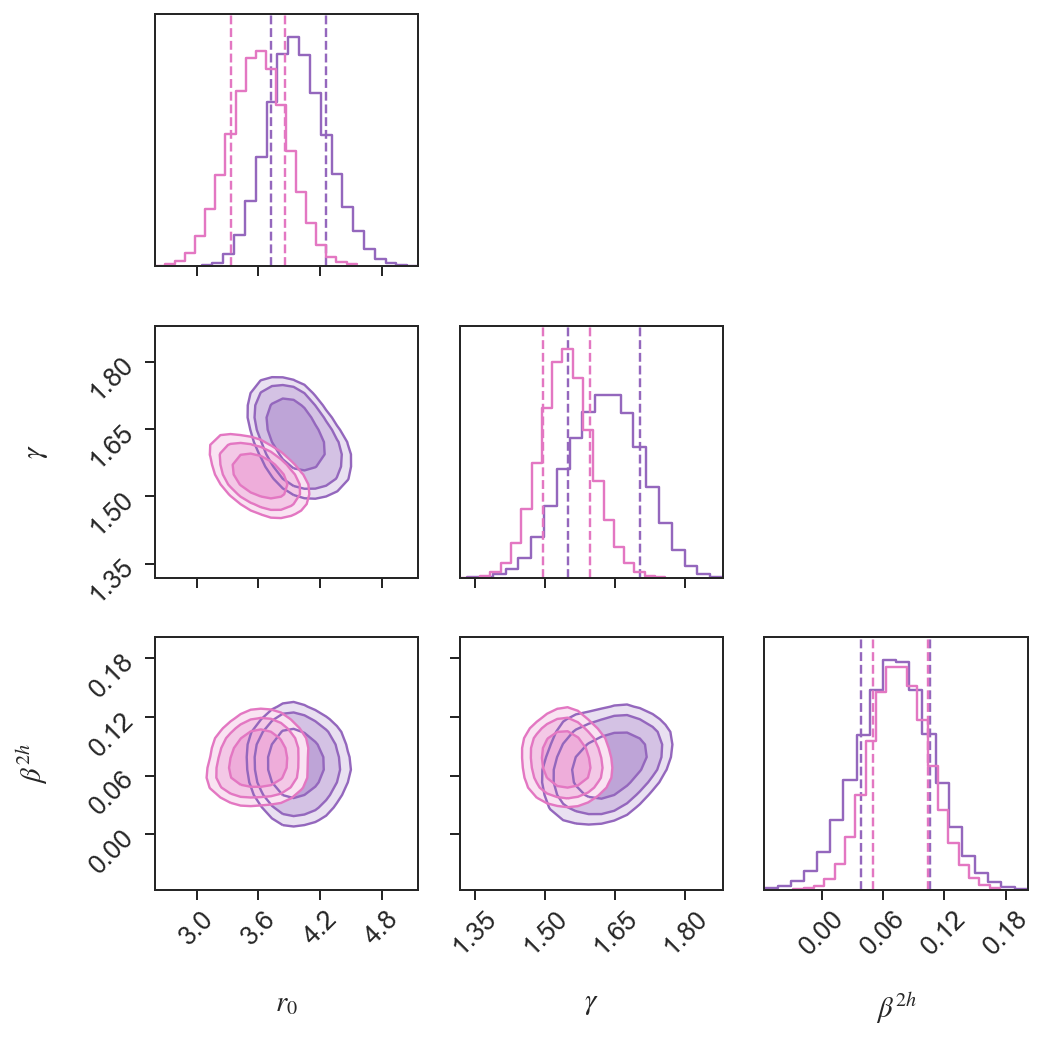

In [11]:
flat1 = sampler.get_chain(discard=2125, thin=1, flat=True)
flat2 = sampler_2h.get_chain(discard=2000, thin=1, flat=True)
levels = (0, 1-np.exp(-0.5), 1-np.exp(-1), 1-np.exp(-1.5))
labels2 = [r"$r_{0}$", r"$\gamma$", r"$\beta^{2h}$", r"$\alpha$", r'$C_0$']
labels1 = [r"$r_{0}$", r"$\gamma$", r"$\beta^{2h}$", r"$A$", r"$R_{\rm cross}$", r"$\beta^{1h}$", r"$\alpha$", r'$C_0$']
weights1=np.ones(len(flat1))/len(flat1)
weights2=np.ones(len(flat2))/len(flat2)
fig = corner.corner(
    flat1[:, :3], labels=labels1, levels=levels, quantiles=[0.16, 0.84], show_titles=False, title_kwargs={"fontsize": 16}, 
    smooth=1, smooth1d=1, labelpad=0.1, plot_datapoints=False, plot_density=False,
    fill_contours=True, weights=weights1, color="tab:purple"
);
corner.corner(flat2[:, :3], labels=labels2, levels=levels, quantiles=[0.16, 0.84], show_titles=False, title_kwargs={"fontsize": 16}, 
    smooth=1, smooth1d=1, labelpad=0.1, plot_datapoints=False, plot_density=False,
    fill_contours=True, weights=weights2, color="tab:pink",fig=fig)
plt.tight_layout()
plt.savefig('../figures/corner_comparison.png', dpi=300)

In [12]:
flat1 = sampler.get_chain(discard=2125, thin=1, flat=True)
flat2 = sampler_2h.get_chain(discard=1000, thin=1, flat=True)
flat1.shape, flat2.shape, weights1.shape

((30000, 8), (30000, 5), (30000,))

# Galaxy bias

In [13]:
from colossus.cosmology import cosmology
from colossus.lss import bias
from colossus.lss import peaks
cosmology.setCosmology('planck15')

Deleted outdated persistence file, no further action needed.


In [14]:

mhalo = np.geomspace(1e10, 1e12, 100) # Msun/h
z = 0.3
b = bias.haloBias(mhalo, model = 'tinker10', z = z, mdef = '200m')

In [15]:
import casbah.gal_properties as caprop
upperm = 10**10.5
sdf = df.query('1e8 < mstars < @upperm')
mstars = np.log10(sdf.mstars.values)
redshift = sdf.z.values
logmhalo = [caprop.calchalomass(m, z) for m, z in zip(mstars, redshift)]

Text(0, 0.5, 'Bias')

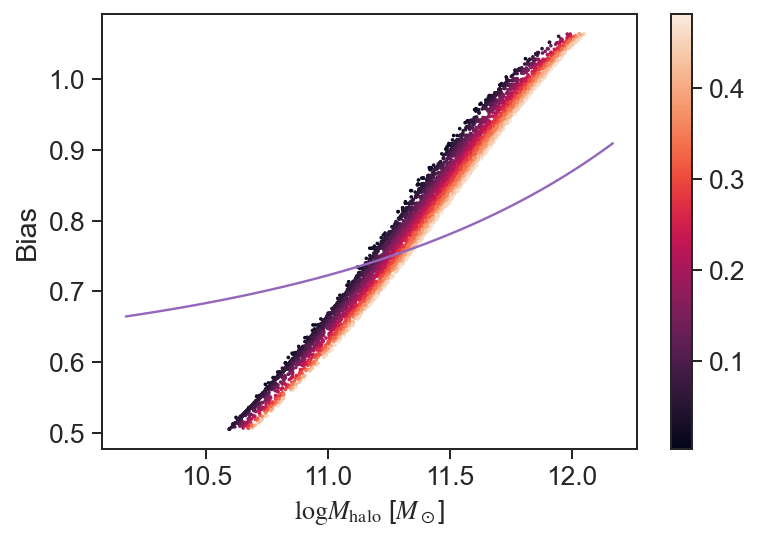

In [16]:
gamma = 1.62
beta2h = 0.08
predicted_bias = (10**(mstars - 9.5))**(gamma*beta2h)
plt.scatter(logmhalo, predicted_bias*0.79, s=1, c=redshift)
plt.colorbar()
plt.plot(np.log10(mhalo/cosmo.h), b, color='tab:purple', label='Tinker10')
plt.xlabel('$\logM_{\mathrm{halo}}$ [$M_\odot$]', fontsize=13);
plt.ylabel('Bias')

# $R_{cross}$ plot with R50

In [17]:
def anti_derivative_full(r0, gamma, r_parallel, r_perpendicular):
    """
    This is the analytic solution to the integrand.

    see the solution at https://www.wolframalpha.com/input/?i=integral+%28sqrt%28x%5E2+%2B+r%5E2%29%2Fr0%29%5E-g


    Args:
        r0: scale length in comoving Mpc
        gamma: power law term.
        r_parallel: the integrand
        r_perpendicular: the rho_comoving_mpc measurements from the galaxies

    Returns:
        full: the anti-derivative

    """
    x = r_parallel
    r = r_perpendicular
    g = gamma
    full = (
        (x * (np.sqrt(r ** 2 + x ** 2) / r0) ** (-g))
        * (1 + x ** 2 / r ** 2) ** (g / 2)
        * sc.hyp2f1(1 / 2, g / 2, 3 / 2, -(x ** 2) / r ** 2)
    )
    return full

def integral_1h(rho, A, sigma, s_eval):
    part1 = np.sqrt(np.pi/2) * sigma * np.exp(-rho**2/(2*sigma**2))
    part2 = sc.erf(s_eval/(np.sqrt(2)*sigma))
    return A * part1 * part2

def integral_2h(rho, s_max, s_eval, r0, gamma):
    part1 = anti_derivative_full(r0, gamma, s_max, rho) # Mpc
    part2 = anti_derivative_full(r0, gamma, s_eval, rho) # Mpc
    return part1 - part2

def chi_perp(r0, gamma, A, sigma, r_cross, rho_gal_com, z_gal, Hz, vmax):
    dv = vmax  # km/s
    a = 1 / (1 + z_gal)
    norm_const = a * Hz / (2 * dv)  # 1/Mpc
    s_max = dv / (a * Hz)  # Mpc
    s_cross = np.sqrt(np.maximum(r_cross**2 - rho_gal_com**2, 0))
    s_eval = np.minimum(s_max, s_cross) 
    integrand = integral_1h(rho_gal_com, A, sigma, s_eval) + integral_2h(rho_gal_com, s_max, s_eval, r0, gamma)
    chi = norm_const * integrand
    return chi

def chi_perp_2h(r0, gamma, rho_gal_com, z_gal, Hz, vmax):
    """compute the integral of the clustering function along the line of site. 
    Use the analytic solution. works for either a single valued r0, gamma or broadcasts
    correctly with r0 ~ Rvir of each galaxy. 

    Args:
        r0 (float, ndarray): scaling factor for the clustering power law. can be a float or an array
            with length matching that of the number of galaxies.
        gamma (float): clustering power law index. 

    Returns:
        ndarray: chi_perp array with length equal to number of galaxies.
    """
    chi_i = c2.chi_perp_analytic(r0, gamma, rho_gal_com, z_gal, Hz, vmax)
    return chi_i

def _choose_rc(rc, A, r0, gamma):
    """ Choose which crossing to use.

    Args:
        rc (_type_): _description_
        A (_type_): _description_
        r0 (_type_): _description_
        gamma (_type_): _description_

    Returns:
        _type_: _description_
    """
    deriv = 2*np.log(A) + gamma*(2*np.log(rc/r0) - 1)
    if np.all(deriv > 0):
        return rc
    else:
        return None

def _calc_sig(rc, A, r0, gamma):
    r = _choose_rc(rc, A, r0, gamma)
    if r is None:
        return None
    else:
        sig = 0.5*r**2 / (np.log(A) + gamma*(np.log(r/r0)))
        return np.sqrt(sig)

def mean_dNdz(z, dndz_index, dndz_coeff, vmax=500.0):
    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(
        z, danforth=False, gamma=dndz_index, coeff=dndz_coeff
    )
    clight = 299792.458
    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    return mean_dN_dz

def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross

def r0_beta(r0, beta2h, mass, m0= 10**9.5):
    r0 = r0*(mass/m0) ** beta2h
    return r0

def phit(params, rho_gal_com, z_gal, Hz, vmax, mass):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params
    r_cross = r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5)
    r0 = r0_beta(r0, beta2h, mass, m0= 10**9.5)
    sigma = _calc_sig(r_cross, A, r0, gamma)
    if sigma is None:
        return None
    chi = chi_perp(r0, gamma, A, sigma, r_cross, rho_gal_com, z_gal, Hz, vmax)
    dndz = mean_dNdz(z_gal, dndz_index, dndz_coeff)
    phit = 1 - np.exp(-(1 + chi)*dndz)
    phit = np.clip(phit, 0.00001, 0.99)
    return phit

def phit_2h(params, rho_gal_com, z_gal, Hz, vmax, mass):
    r0, gamma, beta2h, dndz_index, dndz_coeff = params
    r0 = r0_beta(r0, beta2h, mass, m0= 10**9.5)
    chi = chi_perp_2h(r0, gamma, rho_gal_com, z_gal, Hz, vmax)
    dndz = mean_dNdz(z_gal, dndz_index, dndz_coeff)
    phit = 1 - np.exp(-(1 + chi)*dndz)
    phit = np.clip(phit, 0.00001, 0.99)
    return phit

def r50(fc_list, r_lin):
    r50_idx = np.array([np.argmin(np.abs(fc - 0.5)) for fc in fc_list], dtype="int")
    r50 = r_lin[r50_idx]
    return r50*1e3

def r50_qantiles(fc_list, r_lin):
    fc_lo, fc_med, fc_hi = np.quantile(fc_list, [0.16, 0.5, 0.84], axis=2)

    r50_lo = r50(fc_lo, r_lin)
    r50_med = r50(fc_med, r_lin)
    r50_hi = r50(fc_hi, r_lin)

    return r50_lo, r50_med, r50_hi

In [18]:
flat_samples.shape

NameError: name 'flat_samples' is not defined

In [ ]:


# meandraw = np.nanmean(flat_samples, axis=0)
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)
flat_samples2h = sampler_2h.get_chain(discard=2000, thin=1, flat=True)
r_lin = np.geomspace(0.001, 20, 1000)[:,None]
z_lin = np.mean(df.z_igmsys.values)
hz_lin = cosmo.H(z_lin).value
m_lin = np.geomspace(1e7, 10**11.5, 20)[:, None]
fc_list = np.array([phit(flat_samples[::20].T, r_lin, z_lin, hz_lin, 500.0, m) for m in m_lin])
fc_list2h = np.array([phit_2h(flat_samples2h[::20].T, r_lin, z_lin, hz_lin, 500.0, m) for m in m_lin])


<ipython-input-26-053550d147fb>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  fc_list = np.array([phit(flat_samples[::20].T, r_lin, z_lin, hz_lin, 500.0, m) for m in m_lin])


In [ ]:
fc_list.shape

(20,)

AxisError: axis 2 is out of bounds for array of dimension 1

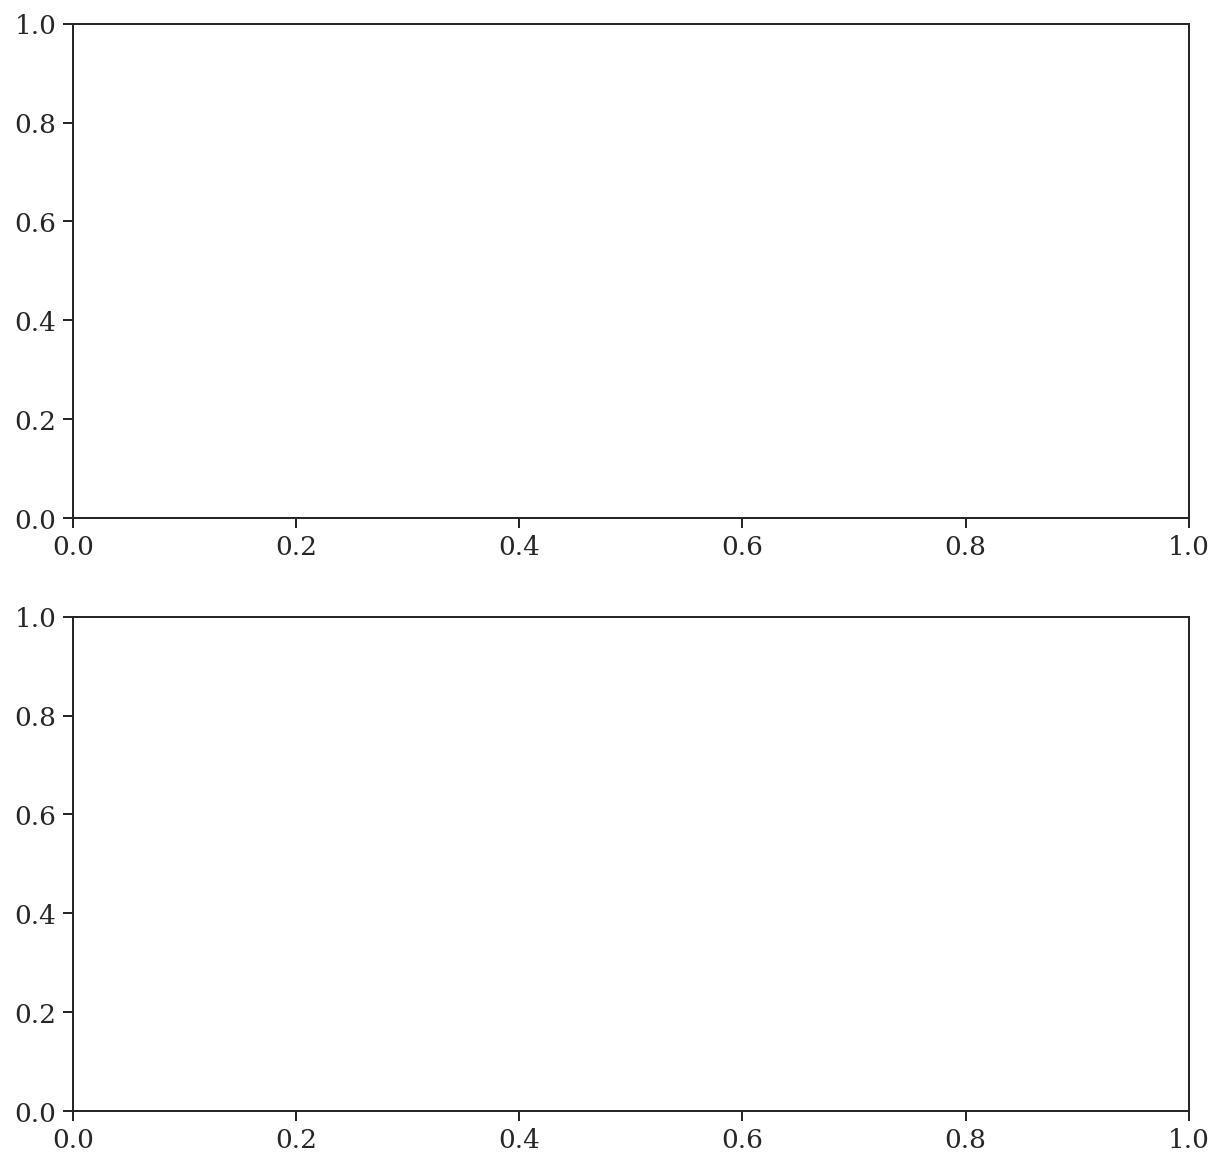

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

for ax, fc in zip(axes, [fc_list, fc_list2h]):
    ax.plot(r_lin, np.mean(fc, axis=2).T)
    ax.set_xscale('log')
    ax.set_yscale('log')

In [ ]:
r50_lo2h, r50_med2h, r50_hi2h = r50_qantiles(fc_list2h, r_lin)
r50_lo, r50_med, r50_hi = r50_qantiles(fc_list, r_lin)

AxisError: axis 2 is out of bounds for array of dimension 1

In [ ]:
plt.plot(np.log10(m_lin) , r50_med)
plt.plot(np.log10(m_lin) , r50_med2h)

NameError: name 'r50_med' is not defined

In [ ]:
r50_lo[:, 0].shape

NameError: name 'r50_lo' is not defined

NameError: name 'm_lin' is not defined

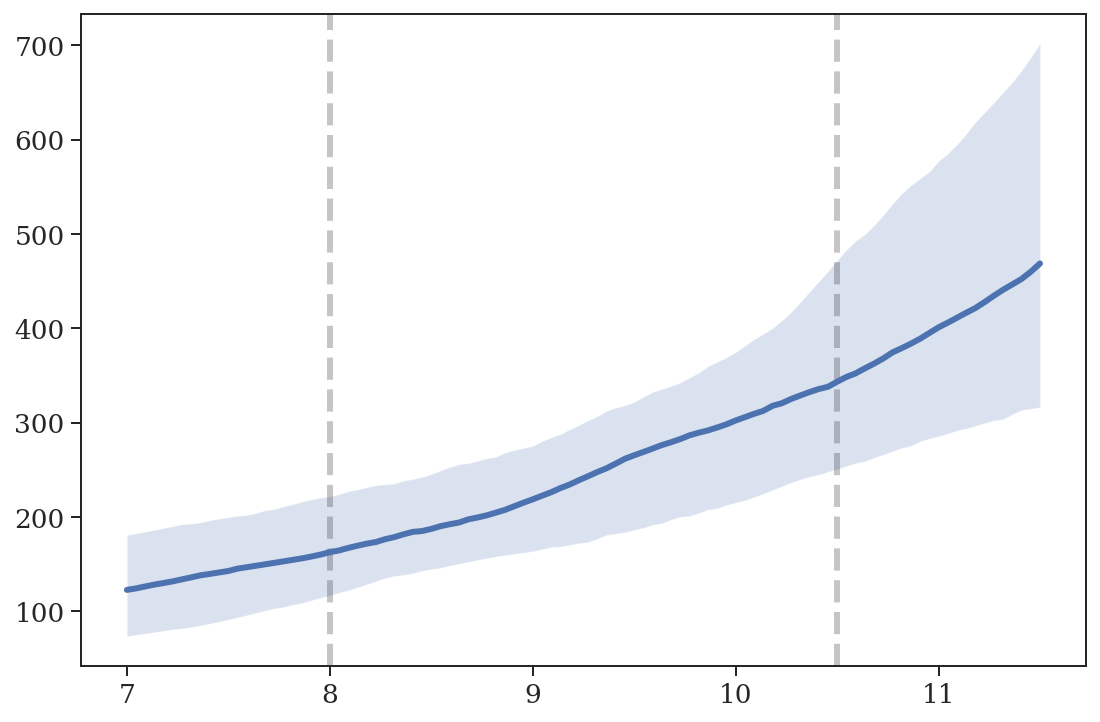

In [38]:
import casbah.gal_properties as caprop
def calc_rvir(mass_space, redshift):
    """caclulate the virial radius of a halo in a given logmstar array and redshift

    Args:
        mass_space (_type_): _description_
        redshift (_type_): _description_

    Returns:
        _type_: _description_
    """
    logmhalo = [
            caprop.calchalomass(mstar, redshift)
            for mstar in mass_space]
    rvir = np.array([caprop.calcrvir(mh, redshift) for mh in logmhalo])
    return rvir


plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 18

flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)

rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
mstars = df.mstars.values[:, None]
mass = np.geomspace(10**8, 10**10.5, 100)[:, None]
mass2 = np.geomspace(10**7, 10**11.5, 100)[:, None]
m0=10**9.5
z = df.z.values[:, None]

def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross

rc_m = r_cross_beta(rc, beta, mass, m0)
rc_m2 = r_cross_beta(rc, beta, mass2, m0)
# kirill: use np.quantile along the mass axis
med, lo, hi = np.quantile(rc_m*1e3, [0.5, 0.16, 0.84], axis=1)
med2, lo2, hi2 = np.quantile(rc_m2*1e3, [0.5, 0.16, 0.84], axis=1)


plt.figure(figsize=(9,6))
# plt.plot(np.log10(mass), rc_m*1000, alpha=0.02, c='xkcd:azure');

# fitting window
plt.axvline(x=8, color='k', linestyle='--', alpha=0.25, lw=3)
plt.axvline(x=10.5, color='k', linestyle='--', alpha=0.25, lw=3)



# rcross
plt.plot(np.log10(mass2), med2, alpha=1, label=r"$R_{\rm cross}}$", lw=3);
# plt.fill_between(np.log10(mass)[:,0], lo, hi, alpha=0.3)
plt.fill_between(np.log10(mass2)[:,0], lo2, hi2, alpha=0.2)

# r50 from paper I
# plt.fill_between(np.log10(m_lin)[:, 0], r50_lo[:, 0], r50_hi[:, 0], alpha=0.2)
plt.plot(np.log10(m_lin)[:, 0], r50_med[:, 0], alpha=1, ls='--', label=r"$R_{\rm 50}$", lw=3)

# r50 from paper I 2h
# plt.fill_between(np.log10(m_lin)[:, 0], r50_lo2h[:, 0], r50_hi2h[:, 0], alpha=0.2)
# plt.plot(np.log10(m_lin)[:, 0], r50_med2h[:, 0], alpha=1, ls='-.', label=r"$R_{\rm 50}^{2h}$")

# error bars from Paper I
xerror = [[1.5, (9.9 - 9.2)/2, (10.5 - 9.9)], [(9.2 - 8.5), 0.35, 0.7]] 

xlist = [8.5, 9.55, 10.5]
ylist = [177, 353, 346]
yerror = np.array([[65, 70], [50, 64], [53, 57]]).T
plt.errorbar(xlist, ylist, xerr=xerror, yerr=yerror, fmt='o', color='k', capsize=2, markersize=4, label=r"$R_{\rm CGM}^{14}$ Wilde+21")

# rvir
plt.fill_between(np.log10(mass2)[:,0], calc_rvir(np.log10(mass2), 0.1), calc_rvir(np.log10(mass2), 0.4), alpha=0.25, label=r'$R_{\rm vir}$', color='k')
plt.xlabel(r"log$_{10}(M_{\star}$)")
plt.ylabel(r"$R$ [ckpc]");
plt.yscale('log')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig("../figures/r_cross_mstar.png", dpi=300)

# plot schematic

In [39]:
def g1h(r, A, sigma):
    return A * np.exp(-r**2 / (2*sigma**2))

def xi2h(r, r0, gamma):
    return (r/r0)**-gamma

def _choose_rc(rc, A, r0, gamma):
    """ Choose which crossing to use.

    Args:
        rc (_type_): _description_
        A (_type_): _description_
        r0 (_type_): _description_
        gamma (_type_): _description_

    Returns:
        _type_: _description_
    """
    deriv = 2*np.log(A) + gamma*(2*np.log(rc/r0) - 1)
    if np.all(deriv > 0):
        return rc
    else:
        return None


def _calc_sig(rc, A, r0, gamma):
    r = _choose_rc(rc, A, r0, gamma)
    if r is None:
        return None
    else:
        sig = 0.5*r**2 / (np.log(A) + gamma*(np.log(r/r0)))
        return np.sqrt(sig)

def sigma_rc(rc, r0, A, gamma):
    return rc/np.sqrt(np.log(1/A)) - gamma*np.log(rc/r0)

0.10089268961755846


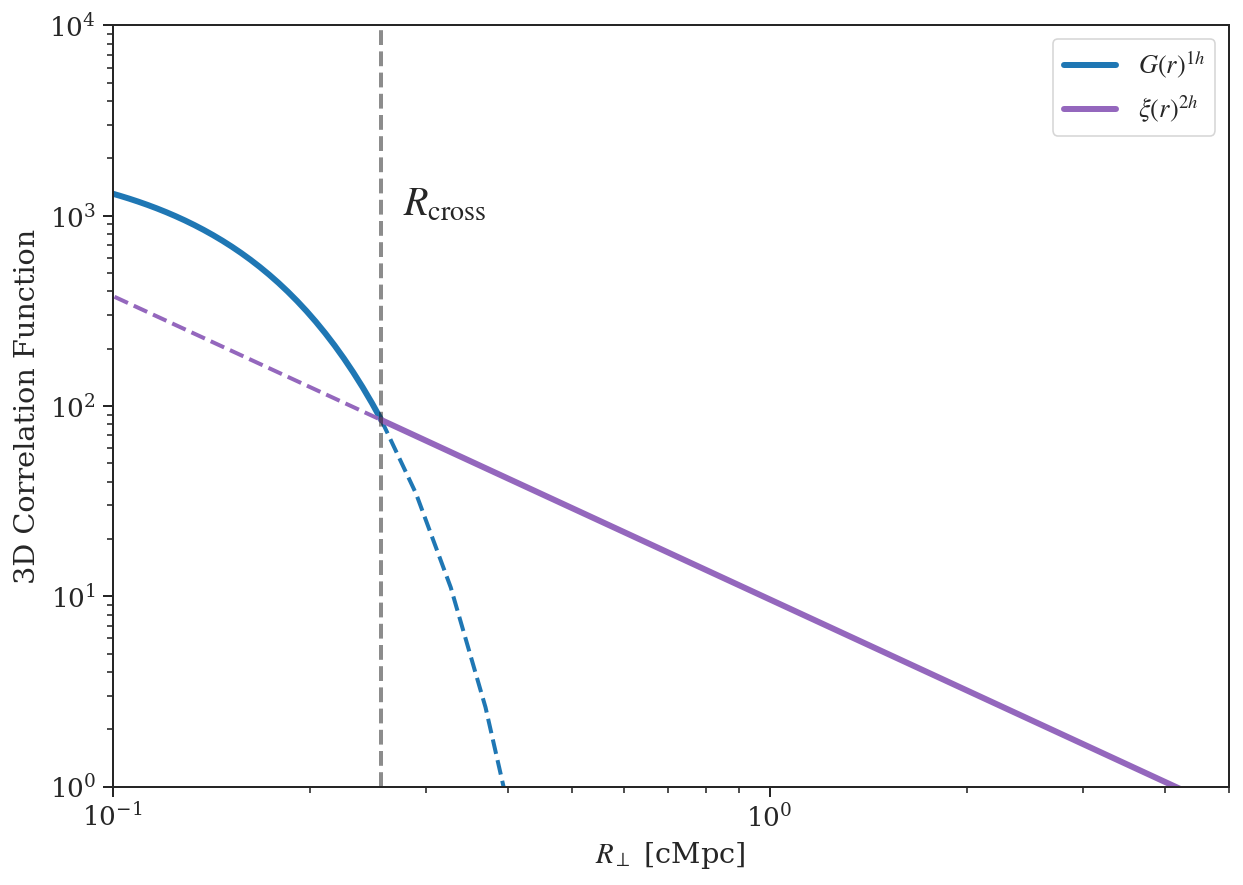

In [50]:
import pickle

plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 20
pkl_file = '../exclusion-model/exclusion_model_gauss_1h_sampler.pkl'
infile = open(pkl_file, "rb")
sampler = pickle.load(infile)
infile.close()
flat_samples = sampler.get_chain(discard=2000, thin=1, flat=True)

r0, gamma, beta2, A, r_cross, beta1, dndz_index, dndz_coeff = flat_samples[-55]
rlin_full = np.geomspace(0.01, 10, 100)
rlin_left = np.geomspace(0.01, r_cross, 100)
rlin_right = np.geomspace(r_cross, 100)


sig = _calc_sig(r_cross, A, r0, gamma)

plt.figure(figsize=(10,7))
plt.plot(rlin_left, g1h(rlin_left, A, sig), label=r"$G(r)^{1h}$", c='tab:blue', lw=3)
plt.plot(rlin_right, g1h(rlin_right, A, sig), c='tab:blue', lw=2, ls='--')
plt.plot(rlin_right, xi2h(rlin_right, r0, gamma), label=r"$\xi(r)^{2h}$", c='tab:purple', lw=3)
plt.plot(rlin_left, xi2h(rlin_left, r0, gamma), c='tab:purple', lw=2, ls='--')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**0, 10**4)
plt.xlim(1e-1, 0.5e1)
plt.axvline(r_cross,  c="k", ls='--', alpha=0.5, lw=2)
plt.legend()
# plt.ylabel(r"$\chi(r)$")
plt.ylabel("3D Correlation Function")
plt.xlabel(r"$R_{\perp}$ [cMpc]")
plt.text(r_cross+0.02, 1e3, r"$R_{\rm cross}$")
plt.savefig('../figures/r_cross_schematic.pdf', dpi=300)
print(sig)

In [ ]:
df.value_counts(df.survey)

survey
CASBaH     6701
CGM$^2$     543
dtype: int64

In [ ]:
df.count()

Name            7244
z               7244
rho             7244
ang_sep         7244
RA              7244
DEC             7244
cosmo           7244
CreationDate    7244
user            7244
HM_0_500        7244
HM_0_100        7244
HM_100_200      7244
HM_200_300      7244
HM_300_400      7244
HM_400_500      7244
mstars          7244
rvir             543
rho_rvir         543
gal_type         543
z_igmsys        7244
log_rho         7244
Hz              7244
logm            7244
survey          7244
dtype: int64

In [ ]:
df.z.min(), df.z.max()

(0.00310574308969, 0.480993837118148)

# X requests a plot

Can you generate a CDF figure of N_hits vs. R_perp?  Data and the 2 models.  This would effectively address item 1.  y-axis may need to be log-scale but maybe not.  x-axis probably should be.

NameError: name 'mass_bin_edges' is not defined

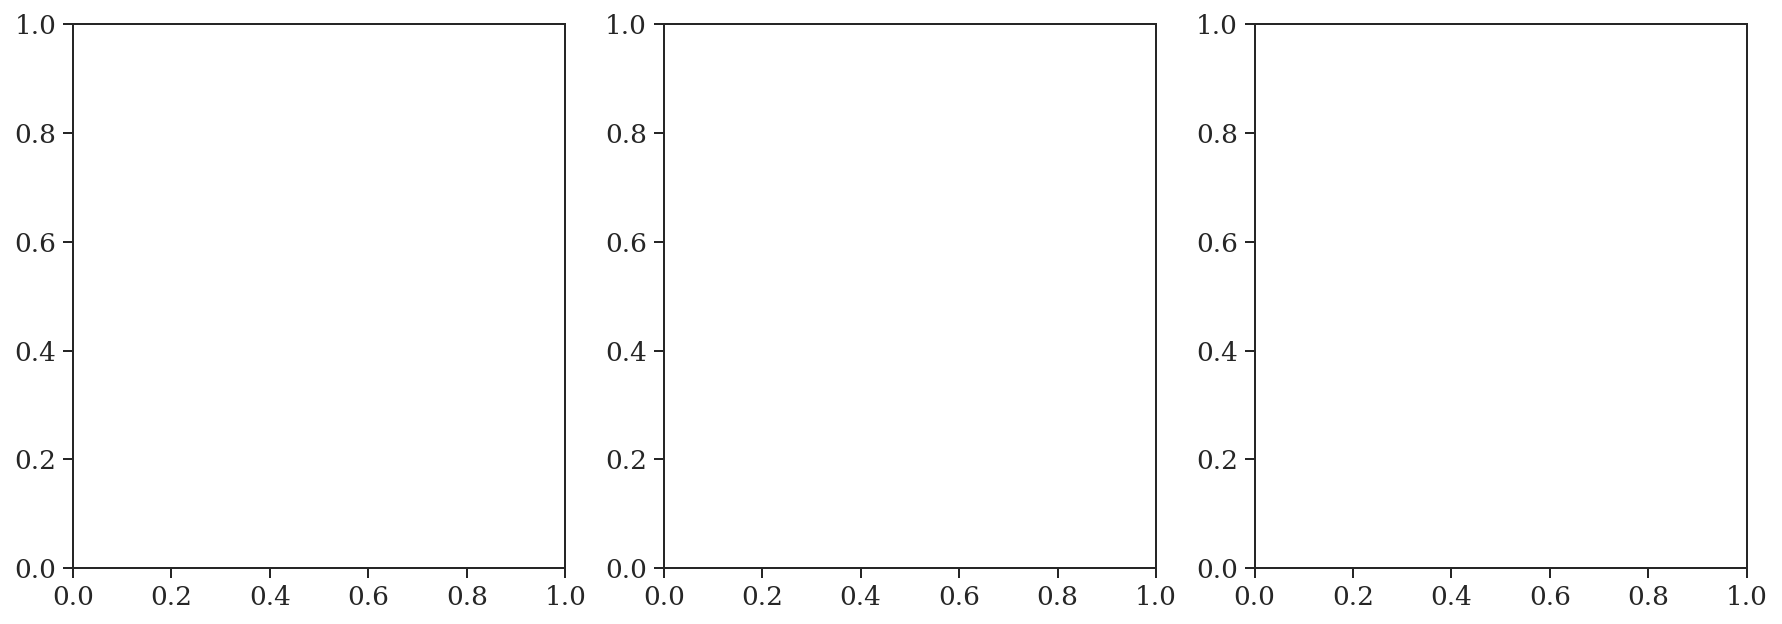

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
outcomes = df.HM_0_500.values
hits = (outcomes == "hit") 
for e, (low, high) in enumerate(zip(mass_bin_edges[:-1], mass_bin_edges[1:])):
    masscut = (10**low < mass) & (mass < 10**high)
    cut = hits & masscut

    axes[e].hist(rho_com[cut], bins=bins, cumulative=1, histtype='step', label='data');
    axes[e].hist(rho_com[masscut], bins=bins, cumulative=1, histtype='step', 
                weights=fc[masscut], label='model');

    if e == 0:
        axes[e].set_ylabel(r'$E[N_{abs}]$')

    text = f"{low} < logM*  < {high}"
    axes[e].text(0.2, 0.1, text, transform=axes[e].transAxes)
    axes[e].set_xlabel('R [cMpc]')
    if e == 1:
        axes[e].set_title(title)

plt.legend(bbox_to_anchor=(1, 0.99));

In [ ]:
def poissonerror(rho, fc, bins):
    # poisson error
    out = binned_statistic(rho, fc, statistic='sum', bins=bins)
    fmean = out[0]
    ferr = np.sqrt(fmean)
    return fmean, ferr

counts < 148.7017036437195]
[4] [7.03802164] [7.33865071]
[2.] [2.65292699] [2.70899441]
poisson error
[4] [7.03802164] [9.69094863]
********************
counts < 192.8011782994607]
[17] [16.70477292] [17.8460824]
[4.12310563] [4.08714728] [4.22446238]
poisson error
[17] [16.70477292] [20.79192021]
********************
counts < 269.3491564661566]
[43] [38.03630045] [41.59771196]
[6.55743852] [6.16735766] [6.44962882]
poisson error
[43] [38.03630045] [44.2036581]
********************
counts < 327.7966909839567]
[24] [24.03965243] [26.69299898]
[4.89897949] [4.90302482] [5.16652678]
poisson error
[24] [24.03965243] [28.94267725]
********************


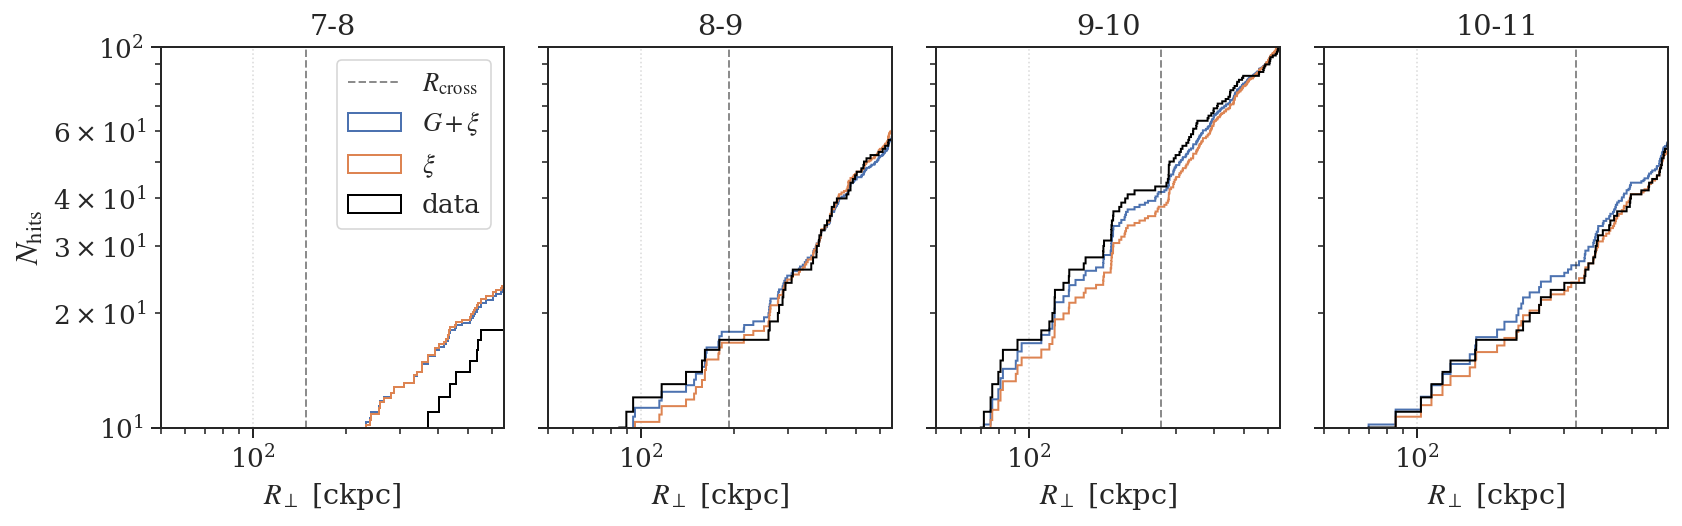

In [ ]:
# this is already done above
# df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
# df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))

rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])
fig, axes = plt.subplots(1, 4, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
m0=10**9.5


def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross


if True:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 11]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    # bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
    #                                             interval='jeffreys')

    # models
    #model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    #print(model[0])
    #model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    
    # ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label=r'$\xi$')
    # ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label=r'$G + \xi$')
    outcomes = ssdf.HM_0_500.values
    hits = (outcomes == "hit")
    fc_model = ssdf.cf_model.values
    fc_model2h = ssdf.cf_model_2h.values
    rho_com = ssdf.rho.values
    # rcross
    rc_m = r_cross_beta(rc, beta, 10**ssdf.logm.mean(), m0)
    med = np.median(rc_m)*1e3

    #rho_bins = [0, med, 1000, 10000, 20e3]
    #rho_bins = [0, med, 20e3]
    rho_bins = ssdf.rho.values
    
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model, label=r'$G + \xi$');
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model2h, label=r'$\xi$');    
    
    ax.hist(rho_com[hits], bins=rho_bins, cumulative=1, histtype='step', label='data', color='black', lw=1)
    ax.axvline(med, c="k", ls='--', alpha=0.5, lw=1, label=r'$R_{\rm cross}$')
    ax.set_title('{}-{}'.format(*rng))
    ax.set_xlabel(r"$R_{\perp}$ [ckpc]")
    ax.set_xlim(5e1, 2*med)
    ax.set_ylim(1e1, 1e2)
    ax.grid(ls=':', color='gainsboro')

    # calculate diff in prediction vs data R<300
    uplim = med
    bin = [0, uplim]
    datacount = np.histogram(rho_com[hits], bins=bin)
    modelcount = np.histogram(rho_com, bins=bin, weights=fc_model)
    model2hcount = np.histogram(rho_com, bins=bin, weights=fc_model2h)
    print(f"counts < {uplim}]")
    print(datacount[0], model2hcount[0],  modelcount[0])
    print(np.sqrt(datacount[0]), np.sqrt(model2hcount[0]), np.sqrt(modelcount[0]))
    # calculate poisson error
    # fdata, fdata_err = poissonerror(rho_com, fc_model, rho_bins)
    f1h, f1h_err = poissonerror(rho_com, fc_model, [0, uplim])
    f2h, f2h_err = poissonerror(rho_com, fc_model2h, [0, uplim])
    print("poisson error")
    # print(f1h, f2h, f1h_err, f2h_err)
    print(datacount[0], f2h, f2h+f2h_err)
    print("*"*20)

axes[0].legend()
plt.xscale('log')

if False:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    # plt.ylim(-0.05, 1.05)
    pass
# axes[1].set_xlabel('IP (ckpc)', fontsize=16)
axes[0].set_ylabel(r'$N_{\rm hits}$', fontsize=16);
plt.yscale('log')


plt.tight_layout();

In [ ]:
datacount = np.histogram(rho_com[hits], bins=[0, 301])
modelcount = np.histogram(rho_com, bins=[0, 301], weights=fc_model)
model2hcount = np.histogram(rho_com, bins=[0, 301], weights=fc_model2h)

In [ ]:
modelcount[0] - 1.96*np.sqrt(modelcount[0]), model2hcount[0] + 1.96*np.sqrt(model2hcount[0])


# correct bin
45.55474929 + 6.74942585

52.30417514

In [ ]:
df['cf_model_lo'] = np.nanquantile(sampler.blobs, 0.16, axis=(0,1))
df['cf_model_hi'] = np.nanquantile(sampler.blobs, 0.84, axis=(0,1))

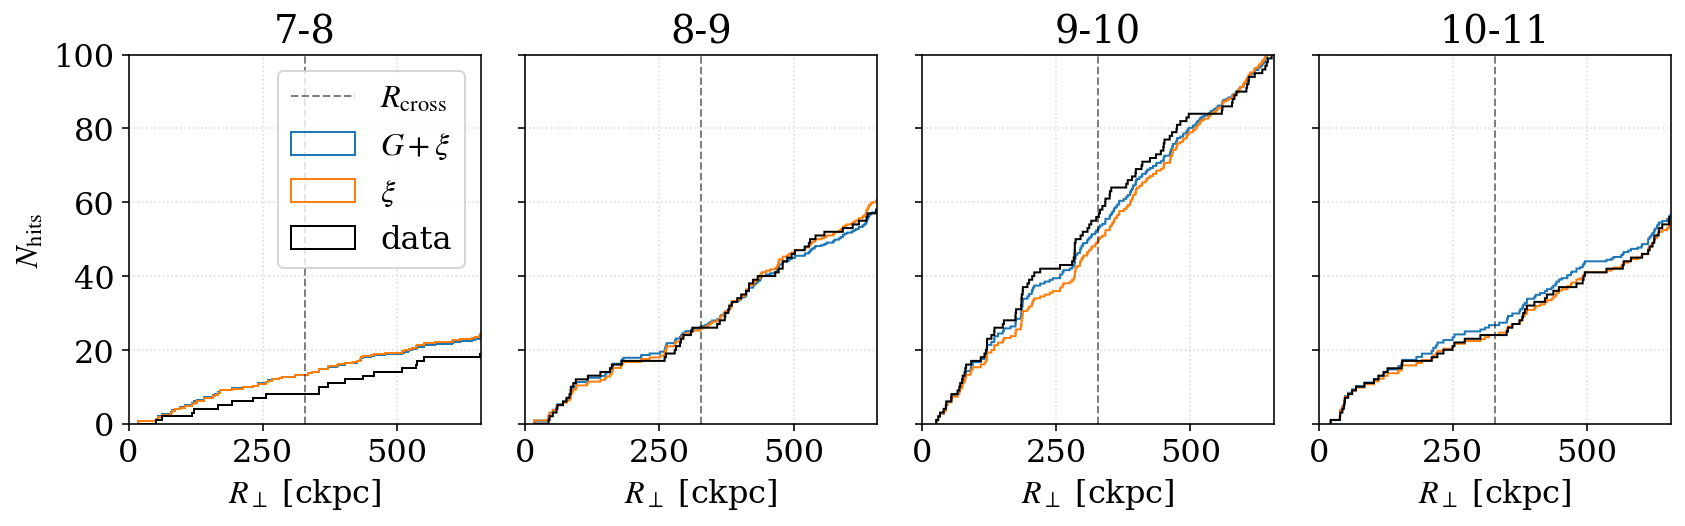

In [ ]:
# this is already done above
# df['cf_model'] = np.nanmean(sampler.blobs, axis=(0,1))
# df['cf_model_2h'] = np.nanmean(sampler_2h.blobs, axis=(0,1))



rho_bins = np.concatenate([[0], np.geomspace(100, 20e3, 11)])
fig, axes = plt.subplots(1, 4, figsize=[12, 4], sharex=True, sharey=True)

hm = 'HM_0_500'

rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
m0=10**9.5


def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross


if True:
    rngs = [[7, 8], [8, 9], [9, 10], [10, 11]]
else:
    rngs = [[8, 9], [9, 10], [10, 11]]

for e, (ax, rng) in enumerate(zip(axes, rngs)):
    ssdf = df.query(f'({rng[0]} < logm < {rng[1]})').copy()
    ssdf['is_hit'] = np.where(ssdf[hm]=='hit', True, False)
    
    # bin_ctr_p, _, p, perr = binned_binom_proportion(ssdf.rho.values, ssdf.is_hit.values, bins=rho_bins,
    #                                             interval='jeffreys')

    # models
    #model = binned_statistic(ssdf.rho.values, ssdf.cf_model.values, bins=rho_bins, )
    #print(model[0])
    #model_2h = binned_statistic(ssdf.rho.values, ssdf.cf_model_2h.values, bins=rho_bins, )
    
    # ax.plot(bin_ctr, model_2h[0], marker='s', mfc='white', mec='tab:pink', mew=2, ls='-', c='tab:pink', label=r'$\xi$')
    # ax.plot(bin_ctr, model[0], marker='D', mfc='white', mec='tab:purple', mew=2, ls='-', c='tab:purple', label=r'$G + \xi$')
    outcomes = ssdf.HM_0_500.values
    hits = (outcomes == "hit")
    fc_model = ssdf.cf_model.values
    fc_model2h = ssdf.cf_model_2h.values
    rho_com = ssdf.rho.values
    # rcross
    rc_m = r_cross_beta(rc, beta, 10**ssdf.logm.mean(), m0)

 


    #rho_bins = [0, med, 1000, 10000, 20e3]
    #rho_bins = [0, med, 20e3]
    rho_bins = ssdf.rho.values
    
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model, label=r'$G + \xi$');
    ax.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
                weights=fc_model2h, label=r'$\xi$'); 


    
    
    ax.hist(rho_com[hits], bins=rho_bins, cumulative=1, histtype='step', label='data', color='black', lw=1)
    ax.axvline(med, c="k", ls='--', alpha=0.5, lw=1, label=r'$R_{\rm cross}$')
    ax.set_title('{}-{}'.format(*rng))
    ax.set_xlabel(r"$R_{\perp}$ [ckpc]")
    log = False
    if log:
        # plt.yscale('log')
        # plt.xscale('log')
        ax.set_xlim(5e1, 2*med)
        ax.set_ylim(1e1, 1e2)
    else:
        ax.set_xlim(0, 2*med)
        ax.set_ylim(0, 100)
    ax.grid(ls=':', color='gainsboro')
axes[0].legend()


if False:
    plt.yscale('log')
    plt.ylim(1e-1, 1.05)
else:
    # plt.ylim(-0.05, 1.05)
    pass
# axes[1].set_xlabel('IP (ckpc)', fontsize=16)
axes[0].set_ylabel(r'$N_{\rm hits}$', fontsize=16);
# plt.yscale('log')
# plt.xscale('log')


plt.tight_layout();

327.7966909839567


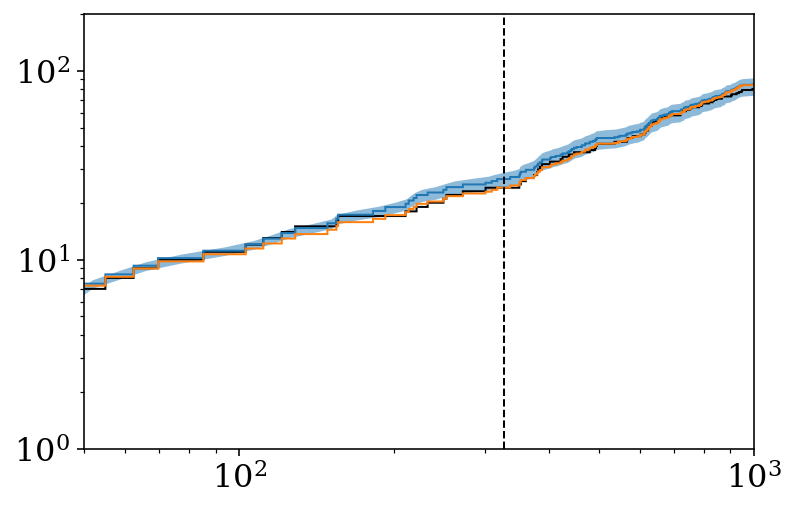

In [ ]:
# plt.fill_between(0.5*(rho_bins[1:] + rho_bins[:-1]), )   

#y_hi, binedges = np.histogram(rho_com, bins=rho_bins, weights=ssdf.cf_model_hi)
#y_med, b = np.histogram(rho_com, bins=rho_bins, weights=ssdf.cf_model)
h_hi, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_hi)
h_lo, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_lo)
dx = bin_edges[1] - bin_edges[0]
f_hi = np.cumsum(h_hi)*dx
f_lo = np.cumsum(h_lo)*dx
plt.fill_between(0.5*(rho_bins[1:] + rho_bins[:-1]), f_lo/17, f_hi/17, lw=2, label='cdf', alpha=0.5)
# y_lo, binedges = np.histogram(rho_com, bins=rho_bins, weights=ssdf.cf_model_lo)
# plt.fill_between(0.5*(rho_bins[1:] + rho_bins[:-1]), y_lo, y_hi, color='tab:blue', alpha=0.5)  
# plt.errorbar(0.5*(rho_bins[1:] + rho_bins[:-1]), y_med, yerr=[med-y_lo, y_hi-med], fmt='o', color='tab:blue', ms=5, lw=1, label='median')
plt.hist(rho_com[hits], bins=rho_bins, cumulative=1, histtype='step', lw=1, color='black', label='data')
plt.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
            weights=fc_model, label=r'$G + \xi$');
plt.hist(rho_com, bins=rho_bins, cumulative=1, histtype='step', lw=1,
            weights=fc_model2h, label=r'$\xi$');    
plt.axvline(med, c="k", ls='--', alpha=1, lw=1, label=r'$R_{\rm cross}$')
print(med)
plt.xlim(5e1, 1e3)
plt.ylim(1e0, 2e2)
plt.xscale('log')
plt.yscale('log')

<ipython-input-149-981aa930383c>:6: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [39.3679163423601 39.761816500011584 40.28796317851641 ...
 19710.920077724568 19807.2721230869 19944.14185569036] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(bin_edges[1:], f_lo, f_hi, 'r-', lw=2, label='cdf', alpha=0.25)


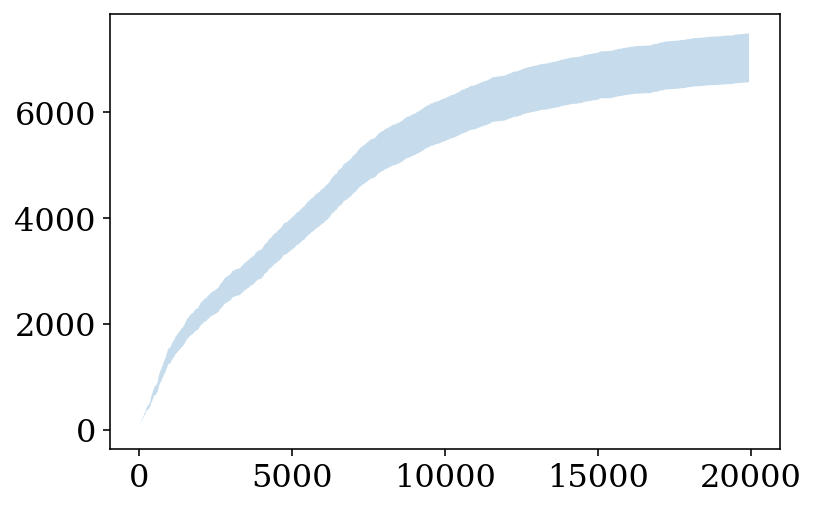

In [ ]:
h_hi, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_hi)
h_lo, bin_edges = np.histogram(rho_com, bins = rho_bins, density=False, weights = ssdf.cf_model_lo)
dx = bin_edges[1] - bin_edges[0]
f_hi = np.cumsum(h_hi)*dx
f_lo = np.cumsum(h_lo)*dx
plt.fill_between(bin_edges[1:], f_lo, f_hi, 'r-', lw=2, label='cdf', alpha=0.25)

array([0.95033706, 0.90956724, 0.9506636 , ..., 0.17826954, 0.20382108,
       0.38614349])

In [ ]:
df

,Name,z,rho,ang_sep,RA,DEC,cosmo,CreationDate,user,HM_0_500,...,rvir,rho_rvir,gal_type,z_igmsys,log_rho,Hz,logm,survey,cf_model,cf_model_2h
0,J1553+3548_318_10,0.082712,16.619888,9.550870,238.268341,35.809929,Planck15,2021-Mar-15,mwilde,miss,...,130.879303,0.117270,SF,0.082555,1.220628,70.501571,8.841201,CGM$^2$,0.779171,0.872142
1,J1437+5045_206_41,0.018490,17.659946,41.247617,219.350861,50.755249,Planck15,2021-Mar-15,mwilde,miss,...,85.604588,0.202570,SF,0.018850,1.246989,68.328814,7.442364,CGM$^2$,0.652194,0.728770
2,J1133+0327_111_5,0.236701,22.505146,4.697760,173.367000,3.454861,Planck15,2021-Mar-15,mwilde,hit,...,523.891170,0.032816,E,0.237347,1.352282,76.503721,10.971467,CGM$^2$,0.950337,0.968900
3,J1241+5721_200_6,0.205262,26.595202,6.350156,190.474000,57.350389,Planck15,2021-Mar-15,mwilde,hit,...,183.087643,0.117362,SF,0.205592,1.424803,75.189212,9.906535,CGM$^2$,0.894498,0.916569
4,J1133+0327_105_6,0.236691,27.860515,5.815880,173.367340,3.454900,Planck15,2021-Mar-15,mwilde,hit,...,1076.360645,0.020930,SF+E,0.237347,1.444989,76.503294,11.283242,CGM$^2$,0.958533,0.964280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7387,J0235-0402_189_2356,0.438236,19807.272123,2356.020207,38.683218,-4.682089,Planck15,2021-Mar-28,jnburchett,miss,...,NaN,NaN,NaN,0.440730,4.296825,85.962183,10.713058,CASBaH,0.205076,0.189654
7388,J0751+2919_56_3394,0.293134,19838.578641,3393.559141,118.704501,29.848535,Planck15,2021-Mar-09,jnburchett,miss,...,NaN,NaN,NaN,0.294790,4.297511,78.974832,8.304075,CASBaH,0.169481,0.151260
7389,J1208+4540_184_3014,0.335515,19944.141856,3014.296823,182.162328,44.841086,Planck15,2021-Mar-28,jnburchett,hit,...,NaN,NaN,NaN,0.335860,4.299815,80.922923,10.529632,CASBaH,0.181068,0.165950
7390,J0751+2919_325_2204,0.477202,19961.539413,2203.667910,117.392278,29.825473,Planck15,2021-Mar-09,jnburchett,miss,...,NaN,NaN,NaN,0.475676,4.300194,87.987543,9.256881,CASBaH,0.211613,0.192601
